In [2]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

[File of logistic.py](https://github.com/Pbabu-Github/csci-0451/blob/main/posts/implementing%20logistic%20regression/logistic.py)

## Abstract
In this blog post, I implemented logistic regression from scratch using PyTorch. I started by creating data to test gradient descent with and without momentum. Then, I created experiments to see how the model behaves under overfitting conditions. Finally, I trained the model on a real-world dataset (Campus Placement Prediction from Kaggle) and evaluated its performance on training, validation, and test splits. This helped me understand how logistic regression works in practice, both on simple and real datasets.

## Experiments
First I am going to setup a function `classification_data` to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍generate ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍for a classification problem in our experiments.

In [3]:
import matplotlib.pyplot as plt
import torch
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

## Vanilla Gradient Descent (when β = 0)

In this experiment, I used logistic regression with vanilla gradient descent, which means I didn’t use any momentum (β = 0). I set the number of features to 2 (p_dims = 2) so that I could plot and visualize the loss later.

The goal here was to check if my implementation works correctly. I trained the model for 100 steps and recorded the loss at each step. The graph shows that the loss decreases over time, which means the model is learning to separate the two classes better.

This experiment helps make sure the basic gradient descent is working as expected.



In [13]:
# Generate data
X, y = classification_data(n_points=300, noise=0.3, p_dims=2)

# Train with vanilla gradient descent
LR_vanilla = LogisticRegression()
opt_vanilla = GradientDescentOptimizer(LR_vanilla)

loss_history_vanilla = []

for _ in range(500): #training model for 500 steps
    loss = LR_vanilla.loss(X, y)
    loss_history_vanilla.append(loss.item())
    opt_vanilla.step(X, y, alpha=0.1, beta=0.0)  # No momentum

## Loss Curve – Vanilla Gradient Descent (β = 0)
This graph shows how the loss changes during training when using vanilla gradient descent (with no momentum). We see that the loss starts around 0.69 and goes down steadily as the number of iterations increases.

This smooth and steady decrease means the model is learning properly, and the gradient descent algorithm is working as expected. There's no sudden jump or spike, which is what we want in a good stable learning process.


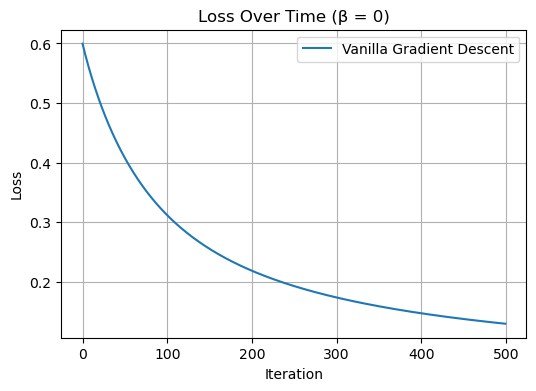

In [14]:

plt.figure(figsize=(6, 4))
plt.plot(loss_history_vanilla, label="Vanilla Gradient Descent")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Over Time (β = 0)")
plt.legend()
plt.grid(True)
plt.show()


## Plotting Decision Boundary for Vanilla dradient descent wehn Paradim = 2

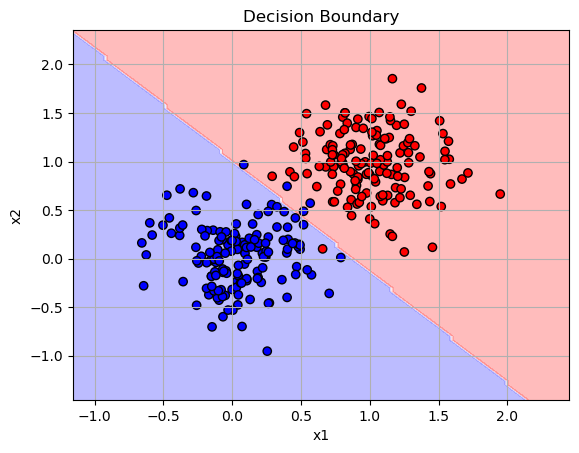

In [20]:
import numpy as np

def plot_decision_boundary(model, X, y):
    x1_min, x1_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    x2_min, x2_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                           np.linspace(x2_min, x2_max, 100))

    # Add bias column to grid
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    grid = np.concatenate([grid, np.ones((grid.shape[0], 1))], axis=1)
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    preds = (torch.sigmoid(model.score(grid_tensor)) >= 0.5).float()
    preds = preds.reshape(xx1.shape)

    plt.contourf(xx1, xx2, preds, alpha=0.3, cmap='bwr')
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Decision Boundary")
    plt.grid(True)
    plt.show()

# Plot decision boundary for vanilla gradient descent
plot_decision_boundary(LR_vanilla, X.numpy(), y.numpy())

## Gradient Descent with Momentum (β = 0.9)
In this experiment, I trained my logistic regression model on the same data, but this time I used momentum with β = 0.9. We use momentum to help the model learn a lot faster. This should make the loss go down a lot more quickly when compaerd to vanilla gradient descent. I kept the learning rate the same and trained the model for 100 steps.

In [15]:
#Training it with momentum now
LR_momentum = LogisticRegression()
opt_momentum = GradientDescentOptimizer(LR_momentum)

loss_history_momentum = []

for _ in range(500): #training model for 500 steps
    loss = LR_momentum.loss(X, y)
    loss_history_momentum.append(loss.item())
    opt_momentum.step(X, y, alpha=0.1, beta=0.9)

## Loss comparison for with and without momentum
The graph belwo compares how the loss changes over time for the two models:

* One trained with no momentum (β = 0, blue line)
* One trained with momentum (β = 0.9, orange line)

We can see that the model with momentum learns much faster. The orange curve drops more quickly and reaches a lower loss in fewer steps. This shows that momentum helps the model converge faster by speeding up learning in the right direction. Whereas the model without moemntum still learns but it is a more slowl. This experiment clearly shows the benefit of using momentum in gradient descent.

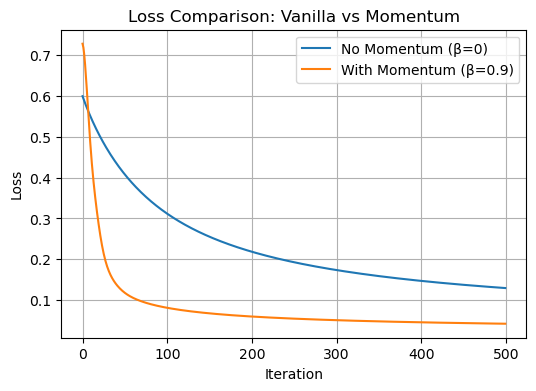

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(loss_history_vanilla, label="No Momentum (β=0)")
plt.plot(loss_history_momentum, label="With Momentum (β=0.9)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Comparison: Vanilla vs Momentum")
plt.legend()
plt.grid(True)
plt.show()


## Plotting Decision Bounday for our data based of our model taht we trained with moemntum

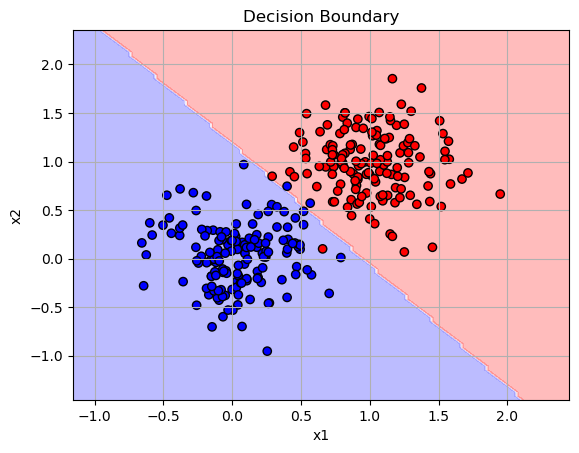

In [19]:
plot_decision_boundary(LR_momentum, X.numpy(), y.numpy())

## Overfitting: High p_dim, Low n_points

In this experiment, I wanted to create a situation where my model would overfit. I set up the data with only 50 examples, but gave each one 100 features (p_dim = 100). This makes it easy for the model to memorize the training data.

To make the overfitting effect more noticeable, I added:

* Low noise to the training data, so the model could learn it perfectly

* High noise to the test data, so it would be much harder and look different

I trained the model using gradient descent with momentum (β = 0.9) for 100 iterations.

The model achieved very high accuracy on the training data, but much lower accuracy on the test data. This showed classic overfitting where my model learned the training examples really well and was not able to generalize to new, (noisier) examples.

In [8]:
# Create overfitting data
X_train, y_train = classification_data(n_points=50, p_dims=100, noise=0.1)
X_test, y_test = classification_data(n_points=50, p_dims=100, noise=0.8)

# Train the model
LR_overfit = LogisticRegression()
opt_overfit = GradientDescentOptimizer(LR_overfit)

for _ in range(100):
    opt_overfit.step(X_train, y_train, alpha=0.1, beta=0.9)

# Evaluate on training and test sets
train_preds = (torch.sigmoid(LR_overfit.score(X_train)) >= 0.5).float()
test_preds = (torch.sigmoid(LR_overfit.score(X_test)) >= 0.5).float()

train_acc = (train_preds == y_train).float().mean().item()
test_acc = (test_preds == y_test).float().mean().item()

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Training Accuracy: 1.00
Test Accuracy: 0.86


## Performance on Empirical Data

**Dataset:** Campus Placement Prediction

I used a dataset from Kaggle called [Campus Placement Prediction](https://www.kaggle.com/datasets/meruvulikith/campus-selection-classification-dataset)@ben_roshan_2024 . This dataset includes information about students such as:

* Education percentages (high school, college, MBA)  
* Degree types and specializations  
* Work experience and test scores  
* Whether they got placed — this is our target variable  

Our goal is to predict the outcome of candidate selection during campus placement processes using logistic regression

For this empirical experiment, I worked with student profiles and their final placement status (placed or not placed). The features include academic scores, education streams, specialization, work experience, and more.

Our target variable is `status` — whether the student was placed (`1`) or not placed (`0`). The task is to predict campus placement outcomes based on these features.

@ben_roshan_2024


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load dataset
df = pd.read_csv("Campus_Selection.csv")  # Make sure the file is in your notebook folder

# Drop rows with missing values
df.dropna(inplace=True)

# Convert target to binary
df['status'] = df['status'].map({'Placed': 1, 'Not Placed': 0})

# Features and target
X_raw = df.drop('status', axis=1)
y = df['status'].values


## Preprocessing the Data
For the preprocessing, I scaled the numeric features (like percentages) so they are all on a similar scale. Then, I one-hot encoded the categorical features (like gender or degree type) to turn them into numbers the model can understand. Finally, I converted everything to PyTorch tensors so I could use them in my logistic regression model.

In [15]:
import numpy as np
import torch

#One hot encoding the categoricals and standarising the numerical colums
cat_cols = X_raw.select_dtypes(include='object').columns.tolist()
num_cols = X_raw.select_dtypes(include='number').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

# Fit transform
X_processed = preprocessor.fit_transform(X_raw)
X_processed = X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed 

# Add bias column of 1s
X_processed = np.concatenate([X_processed, np.ones((X_processed.shape[0], 1))], axis=1)

# Convert to PyTorch
X_tensor = torch.tensor(X_processed, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In my code below I created a function to train logistic regression with a certain beta which will be the momentum for the the training. And, I will plot my loss after.

In [12]:

def train_model(X, y, alpha=0.1, beta=0.0, steps=100):
    model = LogisticRegression()
    optimizer = GradientDescentOptimizer(model)
    losses = []

    for _ in range(steps):
        loss = model.loss(X, y)
        losses.append(loss.item())
        optimizer.step(X, y, alpha=alpha, beta=beta)

    return model, losses

After training the model with and without momentum, I plotted the training loss over time. As expected, the model with momentum (orange) learns faster and reaches a lower loss more quickly than the model without momentum (blue). This shows that momentum helps speed up convergence.

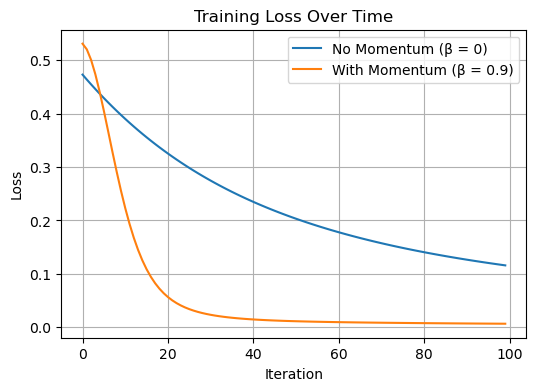

In [13]:
model_nomomentum, loss_no_mom = train_model(X_train, y_train, alpha=0.1, beta=0.0)
model_momentum, loss_with_mom = train_model(X_train, y_train, alpha=0.1, beta=0.9)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(loss_no_mom, label="No Momentum (β = 0)")
plt.plot(loss_with_mom, label="With Momentum (β = 0.9)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

## Evaluating final accuracy for our model on the datset
After training the model on the empirical dataset, I tested it on different splits of the data and got my reults as:

* Training Accuracy: 95%

* Validation Accuracy: 81%

* Test Accuracy: 74%

This shows that the model learned the training data well and also performed reasonably on unseen data, although there is some drop in test accuracy. This is expected and shows that while the model generalizes fairly well, there’s still some fine tuning I could do.

In [21]:
# Split 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # splitting the 40% of data to validation adn test split

model_momentum, loss_with_mom = train_model(X_train, y_train, alpha=0.1, beta=0.9)

def evaluate(model, X, y):
    preds = (torch.sigmoid(model.score(X)) >= 0.5).float()
    accuracy = (preds == y).float().mean().item()
    return accuracy

train_acc = evaluate(model_momentum, X_train, y_train)
val_acc = evaluate(model_momentum, X_val, y_val)
test_acc = evaluate(model_momentum, X_test, y_test)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")


Train Accuracy: 0.95
Validation Accuracy: 0.81
Test Accuracy: 0.74


## Conclusion

What I learned from this project is how to build a working logistic regression model and train it using gradient descent. I tested the effect of momentum and saw that it helps the model learn faster. I also created an overfitting scenario and saw that a model can do really well on the training data but not on unseen data if it’s overfitted.

Finally, I applied the model to a real-world dataset and saw that it achieved high training accuracy and reasonable generalization. This whole process helped me understand how preprocessing, training, and different values of beta (momentum) affect the model’s learning and how they impact the loss over time.